In [1]:
# Import Library 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Dataset path
test_path = '/home/artpark/personal project/Face Mask Detection/data/test/'
train_path = '/home/artpark/personal project/Face Mask Detection/data/train/'

In [3]:
# v = train_path + 'Mask'
# os.listdir(v)

Text(0.5, 1.0, 'With Mask')

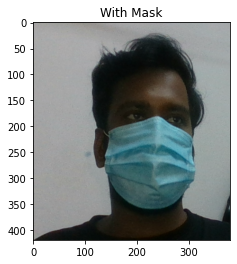

In [4]:
v = test_path + 'Mask'
#os.listdir(v)
img_path = v + '/image1_134.png'
img_r = plt.imread(img_path)
plt.imshow(img_r)
plt.title('With Mask')

Text(0.5, 1.0, 'Without Mask')

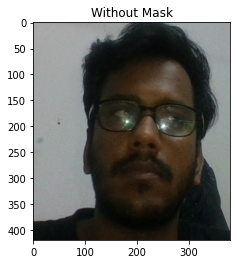

In [5]:
v = test_path + 'NoMask'
#os.listdir(v)
img_path = v + '/image3_27.png'
img_r = plt.imread(img_path)
plt.imshow(img_r)
plt.title('Without Mask')

In [6]:
# Set image shape
image_shape = (370, 430, 3)  # h, w, c
batch_size = 16

In [7]:
# pre-processing of dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range = 10, 
                              width_shift_range = 0.10,
                              height_shift_range = 0.10,
                              rescale = 1/255,
                              shear_range = 0.1,
                              zoom_range = 0.1,
                              horizontal_flip = True,
                              fill_mode = 'nearest')

In [1]:
# Create Train - Test generator, which will used to train the model
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=False)

NameError: name 'image_gen' is not defined

In [9]:
#check
train_image_gen.class_indices

{'Mask': 0, 'NoMask': 1}

In [10]:
##################################################################################################
###########    Transfer Learning  Model  #########################################################
##################################################################################################

In [ ]:
num_class = 1
vgg = VGG16(weights='imagenet',
                 include_top = False,
                 input_shape=image_shape)

for layer in vgg.layers:
    layer.trainable = False

In [11]:
for i, layer in enumerate(resnet.layers):
    print(str(i) + ' ' + layer.__class__.__name__, layer.trainable)

In [13]:
# create transfer learning model
def addTopModel(bottom_model, num_class=1):
    top_model = bottom_model.output
    top_model = Flatten(name = 'Flatten')(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(128, activation='relu')(top_model)
    top_model = Dropout(0.4)(top_model)
    top_model = Dense(32, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    top_model = Dense(num_class, activation='sigmoid')(top_model)
    return top_model

fc_head = addTopModel(vgg, num_class)
model = Model(inputs = resnet.input, outputs = fc_head)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2022-01-04 19:56:52.292432: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 71.50MiB (rounded to 74973184)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-04 19:56:52.292510: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-01-04 19:56:52.292539: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 23, Chunks in use: 23. 5.8KiB allocated for chunks. 5.8KiB in use in bin. 600B client-requested in use in bin.
2022-01-04 19:56:52.292561: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2022-01-04 19:56:52.292580: I tensorflow/cor

ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [ ]:
# Apply early stopping criteria
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
model.fit_generator(train_image_gen, epochs=30, validation_data=test_image_gen, callbacks=[early_stop])

In [ ]:
model.save('FaceMaskDetection_With_Inception2.h5')

In [ ]:
import pandas as pd

loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
print('********************************')
loss[['accuracy', 'val_accuracy']].plot()

In [ ]:
model.evaluate_generator(test_image_gen)

In [ ]:
predd = model.predict_generator(test_image_gen)

In [ ]:
prediction = predd > 0.5

In [ ]:
prediction

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(test_image_gen.classes, prediction))
print('*****************************************************')
print(classification_report(test_image_gen.classes, prediction))

In [ ]:
######################################################################################
############## Load saved Model    ###################################################
######################################################################################

In [ ]:
from tensorflow.keras.models import load_model
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
new_model = load_model('FaceMaskDetection_With_Inception.h5')

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
my_image = image.load_img('325.jpg', target_size=(370, 430))
my_img_arr = image.img_to_array(my_image)
print(my_img_arr.shape)
my_img_arr = np.expand_dims(my_img_arr, axis = 0)
print(my_img_arr.shape)


In [ ]:
predd = new_model.predict(my_img_arr)

In [ ]:
predd

In [ ]:
predd > 0.5